In [8]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import LatticeDefinitions as ld
import GeometryFunctions as gf
import GeneralLattice as gl
import LAMMPSDump as LD
import scipy as sc
from skimage.morphology import skeletonize, thin, medial_axis
import os
from skimage.measure import label, regionprops
from IPython.core.debugger import set_trace

Estimating the triple line energy using curve fitting. 
In theory the potential energy enclosed in a cylinder should follow the following equation 
$P(r) = \pi h P_{volume}r^2 + \left<w\right> \left< \gamma \right> r + f(r)$ 

In [9]:
def CylinderVolume(h, R)->float:
    return np.pi*h*R**2
def PowerRule(r, a,b,c):
    return a*r**b+c
def ProportionalRule(r,m):
    return m*r
def LinearRule(r,m,c):
    return r*m+c 
def Quadratic(r,a,b,c):
    return a*r**2+b*r+c
def TQuadratic(r,b,c):
    return A*r**2+b*r+c
def DiffPowerRule(r,a,b):
    return b*a*r**(a-1)
def AsymptoticLinear(r,a,b):
    return a*r - b*np.log(r+b/a) + b*np.log(b/a)
def DiffAL(r,a,b):
    return a -b/(r+b/a)
def Rational(r,a,b,c):
    return (a*r**3+b)/(r**2+c)
def Composite(r,a,b,c):
    return a*r + b*(r+1)**(-1) +c

In [10]:
x = np.linspace(0,20,40)
#plt.plot(x,AsymptoticLinear(x,15,812))
#plt.scatter(x,Composite(x,2,25,-2))

In [61]:
strDumpFile = '../../PythonLAMMPS/VolumeTest/dump.eam'
strPMFile = strDumpFile + 'PM'
objData = LD.LAMMPSData(strPMFile,1)
objProcess = objData.GetTimeStepByIndex(0)
objProcess.CategoriseAtoms()
a1=4.05
h= 2*a1*np.sqrt(3)
arrTriplePoints = objProcess.FindTriplePoints(a1, 2*a1)
PEVolume= -3.36*4/(a1**3)
lstPE = []
lstValues = []
lstExcess =[]
lstFitExcess = []
lstFitQuadratic = []
lstTotalPE = []
lstTotalGB = []
lstExcessGB = []
lstFitGBExcess = []
lstExcess2 =[]
lstExcess3 = []
intCol = 10 
intPE = objProcess.GetColumnNames().index('c_pe1')
intVS = objProcess.GetColumnNames().index('VolumetricStrain')
fltVolume = np.mean(objProcess.GetLatticeAtoms()[:,intVS])
arrDistance = sc.spatial.distance_matrix(arrTriplePoints[:,0:2],arrTriplePoints[:,0:2])
fltClosest = np.sort(arrDistance[intCol])[1]
fltClosest = 160
fltIncrement = 4.05/4
A =np.median(objProcess.GetLatticeAtoms()[:,intPE])*4*4.05**(-3)*h*np.pi/(1+fltVolume)
fltMedianLatticePE = np.median(objProcess.FindValuesInCylinder(objProcess.GetLatticeAtoms()[:,0:4],
                                                           arrTriplePoints[intCol],fltClosest/2,h,intPE))
fltMedianGBPE = np.median(objProcess.FindValuesInCylinder(objProcess.GetOtherAtoms()[:,0:4],
                                                           arrTriplePoints[intCol],fltClosest/2,h,intPE))
arrCurrentTripleLine = objProcess.MoveToSimulationCell(arrTriplePoints[intCol])
for j in range(1,np.floor(fltClosest/(2*fltIncrement)).astype('int')):
    r = fltIncrement*j
    lstValues.append(r)
    values = objProcess.FindValuesInCylinder(objProcess.GetAtomData()[:,0:4], 
                                             arrCurrentTripleLine, r,h,intPE)
    valuesGB = objProcess.FindValuesInCylinder(objProcess.GetOtherAtoms()[:,0:4], arrCurrentTripleLine,r,h,intPE)
    lstTotalPE.append(np.sum(values))
    lstTotalGB.append(np.sum(valuesGB)-fltMedianGBPE*len(valuesGB))
    lstExcess.append(np.sum(values) -fltMedianLatticePE*len(values))
popt, popv = sc.optimize.curve_fit(Quadratic, lstValues,lstTotalPE)
popt2, popv2 = sc.optimize.curve_fit(LinearRule,lstValues, lstExcess)
for k in lstValues:
    lstFitQuadratic.append(Quadratic(k, A, popt[1], popt[2]))
    lstFitExcess.append(LinearRule(k, *popt2))
    lstExcess2.append(lstExcess[j]-popt2[0]*lstValues[j])
print(popt,popt2, A)
plt.scatter(lstValues, lstTotalPE)
plt.plot(lstValues, lstFitQuadratic, c='r')
plt.show()
lstExcess2 = []
lstDifference = []
for j in range(len(lstValues)):
    lstExcess2.append(lstExcess[j] -popt2[0]*lstValues[j])
    lstExcess3.append(lstExcess[j] -lstTotalGB[j])
plt.scatter(lstValues, lstExcess2)
plt.show()
plt.scatter(lstValues, lstTotalGB)
plt.show()

IndexError: list index out of range

In [15]:
r = np.correlate(lstExcess2,lstExcess2,mode='full')[len(lstExcess2)-1:]
print(np.argmax(r))

0


array([-2.93487497e-08+0.j        ,  3.69535837e+01-0.42514608j,
        2.26573237e+00+9.76504509j,  1.00441701e+01+1.09463811j,
        4.40042889e+00-2.37021476j, -8.97697976e-01+1.76894634j,
        9.16082220e-01+2.99756332j,  2.27598205e+00+0.70102959j,
        2.47691228e+00+1.89867062j, -1.15947903e-01-0.08190208j,
       -4.18067312e-01-1.60908415j,  2.63939885e-01-1.15448464j,
        5.95866163e-01+0.8506485j ,  4.30002372e-01+0.2302055j ,
        1.14620410e+00+0.1028236j ,  1.60789156e+00-1.05419039j,
        2.50445774e+00+0.3236433j , -1.66771883e+00+0.57275294j,
       -1.96222892e-01+0.650059j  ,  1.19916653e+00+1.15077658j,
        1.19916653e+00-1.15077658j, -1.96222892e-01-0.650059j  ,
       -1.66771883e+00-0.57275294j,  2.50445774e+00-0.3236433j ,
        1.60789156e+00+1.05419039j,  1.14620410e+00-0.1028236j ,
        4.30002372e-01-0.2302055j ,  5.95866163e-01-0.8506485j ,
        2.63939885e-01+1.15448464j, -4.18067312e-01+1.60908415j,
       -1.15947903e-01+0.

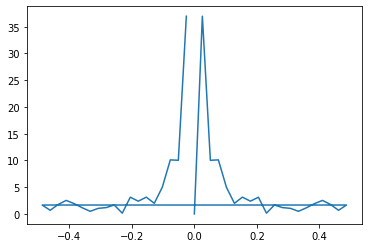

In [24]:
arrfft = np.fft.fft(lstExcess2)
arrAmplitude = np.abs(arrfft)
arrFrequency = np.fft.fftfreq(len(arrAmplitude))
plt.plot(arrFrequency, arrAmplitude)
arrfft


In [ ]:
print(objProcess.MoveToSimulationCell(arrTriplePoints), objProcess.MergePeriodicTripleLines(a1))



In [ ]:
def PotentialEnergyInVolume(arrTriplePoint: np.array, fltRadius:float, fltHeight :float)->float:
    arrTriplePoints = objProcess.PeriodicEquivalents(arrTriplePoint)
    lstPoints = []
    for j in arrTriplePoints:
        lstPoints.extend(np.where(np.linalg.norm(objProcess.GetAtomData()[:,1:3]-j[0:2],axis=1) 
                         <fltRadius)[0])
    lstPoints = list(np.unique(lstPoints))
    return (np.sum(objProcess.GetAtomData()[lstPoints][:,7])/CylinderVolume(fltHeight,fltRadius)) 

In [ ]:
def PotentialEnergyPerAtom(arrTriplePoint: np.array, fltRadius:float, fltHeight :float)->float:
    arrTriplePoints = objProcess.PeriodicEquivalents(arrTriplePoint)
    lstPoints = []
    for j in arrTriplePoints:
        lstPoints.extend(np.where(np.linalg.norm(objProcess.GetAtomData()[:,1:3]-j[0:2],axis=1) 
                         <fltRadius)[0])
    lstPoints = list(np.unique(lstPoints))
    return (np.sum(objProcess.GetAtomData()[lstPoints][:,7])/len(lstPoints)) 

In [ ]:
def FormPotentialListVolume(intLength: int, flta: float, flth: float, arrPoint: np.array)->list:
    Radii = np.linspace(flta/(np.sqrt(2)),0.5*intLength*flta/(np.sqrt(2)),intLength)
    lstPotentialValues = []
    for r in Radii:
        lstPotentialValues.append(PotentialEnergyInVolume(arrPoint, r,flth))
    return Radii,lstPotentialValues

In [ ]:
def FormPotentialListAtom(intLength: int, flta: float, flth: float, arrPoint: np.array)->list:
    Radii = np.linspace(flta/(np.sqrt(2)),0.5*intLength*flta/(np.sqrt(2)),intLength)
    lstPotentialValues = []
    for r in Radii:
        lstPotentialValues.append(PotentialEnergyPerAtom(arrPoint, r,flth))
    return Radii,lstPotentialValues

In [ ]:
fig,axs = plt.subplots(len(arrTriplePoints),2, figsize = (15,50))
fig.subplots_adjust(hspace =1)
axs= axs.ravel()
for pos,j in enumerate(arrTriplePoints):
    axs[2*pos].scatter(*FormPotentialListVolume(25, a1, 2*a1, j))
    axs[2*pos+1].scatter(*FormPotentialListAtom(25, a1, 2*a1, j))
    axs[2*pos].set_title('Triple line mean position is '+ str(np.round(j)))
    axs[2*pos+1].set_title('Triple line mean position is '+ str(np.round(j)))
    axs[2*pos].set_ylabel('Potential Energy per Unit Volume in eV per $\AA^3$' )
    axs[2*pos].set_xlabel('Radial distance from triple line axis in $\AA$')
    axs[2*pos+1].set_ylabel('Potential Energy per atom in $eV$' )
    axs[2*pos+1].set_xlabel('Radial distance from triple line axis in $\AA$')

In [ ]:
-3.36*4/(4.05**3) #FCC cell has 4 atoms in a perfect lattice each atom is approx -3.36 eV 
len(arrTriplePoints)

In [ ]:
arrTriplePoints = objProcess.FindTriplePoints(4.05,4.05, True)
arrGrainBoundaries = objProcess.GetGrainBoundaries()
print(arrTriplePoints)

In [ ]:
def GetGrainBoundarySegments(objGB, fltWidth: float):
    #arrPoints = gf.SortInDistanceOrder(arr2DPoints[:,0:2])[0]
    lstPositions =[]
    lstTotalPE = []
    lstTotalPositions = []
    for j in range(0,objGB.GetNumberOfPoints()-1):
        arrVector = objGB.GetVector(j)
        arrAcross = fltWidth*objGB.GetAcrossVector(j)
        arrCentre3d = objGB.GetCentre(j) 
        arrCentre3d[2] = 4.05
        lstPositions = objProcess.FindBoxAtoms(arrCentre3d[0:2],arrVector[0:2],arrAcross[0:2])
      #  lstPositions = objProcess.FindCylindricalAtoms(np.array([arrPoints[j][0],arrPoints[j][1],0]), fltWidth)
        lstPositions = list(np.unique(lstPositions))
        lstTotalPE.append(np.sum(objProcess.GetRows(lstPositions)[:,intPE]))
        lstTotalPositions.extend(objProcess.GetRows(lstPositions)[:,1:3])
    lstTotalPositions = np.array(lstTotalPositions)
    return lstTotalPE, lstTotalPositions

In [ ]:
arrGrainBoundaries = objProcess.GetGrainBoundaries()
fig,axs = plt.subplots(len(arrGrainBoundaries),2, figsize = (15,50))
fig.subplots_adjust(hspace =1)
axs= axs.ravel()
lstPE = []
lstPositions = []
fltWidth= 4*a1
for j in range(len(arrGrainBoundaries)):
    if len(arrGrainBoundaries[j]) > 2: 
        lstLengths = []
        objGB = gl.GrainBoundary(arrGrainBoundaries[j])
        
        lstPE, lstPositions = GetGrainBoundarySegments(objGB, fltWidth)
        for k in range(len(lstPE)):
            lstLengths.append(objGB.GetAccumulativeLength(k))
            lstPE[k] = lstPE[k]/(objGB.GetSegmentLength(k)*fltWidth*h)
        axs[2*j].set(xlim=(0, objProcess.GetCellVectors()[0][0]+objProcess.GetCellVectors()[1][0]),
                     ylim = (0,objProcess.GetCellVectors()[1][1]))
        axs[2*j].axis('equal')
        axs[2*j].scatter(lstPositions[:,0],lstPositions[:,1])
        axs[2*j].scatter(objGB.GetPoints()[:,0],objGB.GetPoints()[:,1])
        axs[2*j+1].scatter(lstLengths,lstPE)
        axs[2*j].set_title('Atomic Positions for Grain Boundary '+ str(np.round(j)))
        axs[2*j+1].set_title('Potential Energy in $eV$ for Grain Boundary '+ str(np.round(j)))
        axs[2*j].set_ylabel('Position in $\AA$' )
        axs[2*j].set_xlabel('Position in $\AA$')
        axs[2*j+1].set_ylabel('Potential Energy per atom in eV$' )
        axs[2*j+1].set_xlabel('Approximate Position Number on Grain Boundary')

In [ ]:
fig,axs = plt.subplots(len(arrGrainBoundaries),1, figsize = (15,50))
fig.subplots_adjust(hspace =1)
axs= axs.ravel()
for j in range(len(arrGrainBoundaries)):
    if len(arrGrainBoundaries[j]) > 1:
        objGB2 = gl.GrainBoundary(arrGrainBoundaries[j])
        lstPE = []
        lstWidth =[]
        for k in range(2,12):
            lstPE.append(np.mean(GetGrainBoundarySegments(objGB2, k*a1/4)[0]))
            lstWidth.append(k*a1/2) 
            
        axs[j].scatter(lstWidth,lstPE)
        axs[j].set_title('PE per Atom Against Cuboid Width '+ str(np.round(j)))
        axs[j].set_ylabel('PE per Atom in $eV$$' )
        axs[j].set_xlabel('Cuboid Width in $\AA$')
            

In [ ]:
def TurningRegion(arrPoints, arrAcross1,arrAcross2, fltWidth)->list:
    lstIndices = []
    arrUnit1 = gf.NormaliseVector(arrAcross1[0:2])
    arrUnit2 = gf.NormaliseVector(arrAcross2[0:2])
    fltDirection = np.sign(np.cross(arrAcross1, arrAcross2)[2])
    if fltDirection < 0: 
        lstIndices.extend(np.where((np.dot(arrPoints,arrUnit1) > 0) & (np.dot(arrPoints,arrUnit1) < fltWidth)
                             & (np.dot(arrPoints,arrUnit2) > 0) & (np.dot(arrPoints,arrUnit2) < fltWidth))[0])
    elif fltDirection > 0:
        lstIndices.extend(np.where((np.dot(arrPoints,arrUnit1) < 0) & (np.dot(arrPoints,arrUnit1) > -fltWidth)
                                  & (np.dot(arrPoints,arrUnit2) < 0) & (np.dot(arrPoints,arrUnit2) > -fltWidth))[0])
    return list(lstIndices)

In [ ]:
objGB1 = gl.GrainBoundary(arrGrainBoundaries[5])
lstPoints = TurningRegion(objProcess.GetAtomData()[:,1:3]-objGB1.GetPoints(6)[0:2], objGB1.GetVector(0), 
              objGB1.GetVector(8), 1)
plt.scatter(objProcess.GetRows(lstPoints)[:,1],objProcess.GetRows(lstPoints)[:,2]);

In [ ]:
np.where(np.dot(objProcess.GetAtomData()[:,1:3]-objGB1.GetPoints(1)[0:2],
                gf.NormaliseVector(objGB1.GetVector(1))[0:2])<0)

In [ ]:
objGB1.GetVector(5)

In [ ]:
def GetGrainBoundary(objGB, fltWidth: float):
    #arrPoints = gf.SortInDistanceOrder(arr2DPoints[:,0:2])[0]
    lstPositions =[]
    lstTotalPE = []
    lstTotalPositions = []
    lstArcs = []
    arrFirstCentre = objGB.GetCentre(0)
    lstArcs.extend(gf.ArcSegment(objProcess.GetAtomData()[:,1:3]-arrFirstCentre[0:2],
                           objGB.GetAcrossVector(0)[0:2], -objGB.GetAcrossVector(0)[0:2], fltWidth))
    lstArcs.extend(gf.ArcSegment(objProcess.GetAtomData()[:,1:3]-arrFirstCentre[0:2],
                           objGB.GetAcrossVector(-1)[0:2], -objGB.GetAcrossVector(-1)[0:2], fltWidth))
    for j in range(0,objGB.GetNumberOfPoints()-1):
        arrVector = objGB.GetVector(j)
        arrAcross = fltWidth*objGB.GetAcrossVector(j)
        arrCentre3d = objGB.GetCentre(j) 
        arrCentre3d[2] = 4.05
        lstPositions.extend(objProcess.FindBoxAtoms(arrCentre3d[0:2],arrVector[0:2],arrAcross[0:2]))
        if j > 1:
            lstPositions.extend(gf.ArcSegment(objProcess.GetAtomData()[:,1:3]-arrCentre3d[0:2],
                           objGB.GetAcrossVector(j)[0:2], objGB.GetAcrossVector(j-1)[0:2], fltWidth))
            lstPositions.extend(gf.ArcSegment(objProcess.GetAtomData()[:,1:3]-arrCentre3d[0:2],
                           -objGB.GetAcrossVector(j)[0:2], -objGB.GetAcrossVector(j-1)[0:2], fltWidth))
      #  lstPositions = objProcess.FindCylindricalAtoms(np.array([arrPoints[j][0],arrPoints[j][1],0]), fltWidth)
        lstPositions = set(np.unique(lstPositions))
        lstPositions.difference(lstArcs)
        lstPositions = list(lstPositions)
        lstTotalPE.append(np.sum(objProcess.GetRows(lstPositions)[:,intPE]))
        lstTotalPositions.extend(objProcess.GetRows(lstPositions)[:,1:3])
    lstTotalPositions = np.array(lstTotalPositions)
    return lstTotalPE, lstTotalPositions

In [ ]:
GetGrainBoundary(objGB2,5)

In [ ]:
objGB2.GetAcrossVector(1)

In [ ]:
arrGrainBoundaries = objProcess.GetGrainBoundaries()
fig,axs = plt.subplots(len(arrGrainBoundaries),2, figsize = (15,50))
fig.subplots_adjust(hspace =1)
axs= axs.ravel()
lstPE = []
lstPositions = []
fltWidth= 2*a1
for j in range(len(arrGrainBoundaries)):
    if len(arrGrainBoundaries[j]) > 2: 
        lstLengths = []
        objGB = gl.GrainBoundary(arrGrainBoundaries[j])
        
        lstPE, lstPositions = GetGrainBoundary(objGB, fltWidth)
        for k in range(len(lstPE)):
            lstLengths.append(objGB.GetAccumulativeLength(k))
            lstPE[k] = lstPE[k]/(objGB.GetSegmentLength(k)*fltWidth*h)
        axs[2*j].set(xlim=(0, objProcess.GetCellVectors()[0][0]+objProcess.GetCellVectors()[1][0]),
                     ylim = (0,objProcess.GetCellVectors()[1][1]))
        axs[2*j].axis('equal')
        axs[2*j].scatter(lstPositions[:,0],lstPositions[:,1])
        axs[2*j].scatter(objGB.GetPoints()[:,0],objGB.GetPoints()[:,1])
        axs[2*j+1].scatter(lstLengths,lstPE)
        axs[2*j].set_title('Atomic Positions for Grain Boundary '+ str(np.round(j)))
        axs[2*j+1].set_title('Potential Energy in $eV$ for Grain Boundary '+ str(np.round(j)))
        axs[2*j].set_ylabel('Position in $\AA$' )
        axs[2*j].set_xlabel('Position in $\AA$')
        axs[2*j+1].set_ylabel('Potential Energy per atom in eV$' )
        axs[2*j+1].set_xlabel('Approximate Position Number on Grain Boundary')

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
lstP = gf.CylindricalVolume(objProcess.GetAtomData()[:,1:4], arrTriplePoints[10], 15, objProcess.CellHeight)
ax.scatter(objProcess.GetRows(lstP)[:,1], objProcess.GetRows(lstP)[:,2],objProcess.GetRows(lstP)[:,3])

In [ ]:
objProcess.FindNonGrainMean(np.array([0,0,0]), 8)


In [ ]:
CellArray = plt.imread('../../PythonLAMMPS/VolumeTest/CellView.png')
CellArray = np.flip(CellArray, axis=0)
plt.matshow(CellArray[:,:,:], origin = 'lower')

In [ ]:
def ConvertToImage(vctImageAcross: np.array, vctImageDiagonal: np.array, 
                   arrPoints: np.array, arrMatrix: np.array)->np.array:
    arrNewPoints = np.matmul(arrPoints, arrMatrix)
    arrNewPoints = np.mod(arrNewPoints, np.ones(3))
    arrReturn2DPoints = np.zeros([len(arrNewPoints),2])
    for j, point in enumerate(arrNewPoints):
        arrReturn2DPoints[j] = point[0]*vctImageAcross + point[1]*vctDiagonal
    

In [ ]:
n = 5
intUp, intAcross = np.shape(CellArray)[0:2]
#arrTriplePoints = objProcess.MoveToSimulationCell(arrTriplePoints)
NewTriplePoints = np.matmul(arrTriplePoints, objProcess.GetBasisConversions())
NewTriplePoints = np.mod(NewTriplePoints, np.ones(3))
fltBase = intUp/np.tan(np.pi/3)
vctAcross = np.array([intAcross-fltBase, 0])
vctDiagonal = np.array([fltBase, intUp])
for j in NewTriplePoints:
    arrCurrentPoint = j[0]*vctAcross + j[1]*vctDiagonal
    #arrCurrentPoint[0] = j[0]/np.linalg.norm(objProcess.GetCellVectors()[0])*intDown
    #arrCurrentPoint[1] = (1-j[1]/np.linalg.norm(objProcess.GetCellVectors()[1]))*intDown
    CellArray[arrCurrentPoint[1].astype('int')-n:arrCurrentPoint[1].astype('int')+n, 
              arrCurrentPoint[0].astype('int')-n:arrCurrentPoint[0].astype('int')+n,0] =1
plt.matshow(CellArray, origin = 'lower')

In [ ]:
arrPoint = objProcess.GetTripleLines()[0]
lstIndices = gf.CylindricalVolume(objProcess.GetLatticeAtoms()[:,1:4], arrPoint,2*a1, h )
#lstIndices = objProcess.FindCylindricalAtoms(objProcess.GetOtherAtoms()[:1:4], arrPoint, 2*a1,h)
arrCylinder = objProcess.GetLatticeAtoms()[lstIndices, 1:4]

In [ ]:
plt.scatter(arrCylinder[:,0],arrCylinder[:,1])


In [ ]:
print(arrPoint, np.mean(arrCylinder, axis=0), len(arrCylinder))


In [ ]:
objProcess.GetNumberOfLatticeAtoms()
